In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
from sklearn.model_selection import train_test_split 
from transformers import TFViTForImageClassification, DeiTImageProcessor
from tqdm import tqdm
import cv2 
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Global Configurations 
DATA_DIR = '.' 
IMG_SIZE = 224
MODEL_NAME = "facebook/deit-base-patch16-224"
BATCH_SIZE = 16

TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
LABELS_PATH = os.path.join(DATA_DIR, 'labels.csv')
BREEDS_PATH = os.path.join(DATA_DIR, 'dog_breeds.pkl')
CHECKPOINT_PATH = os.path.join(DATA_DIR, 'deit_finetuned.keras')

#creating pkl of all the breeds for mapping
df_labels = pd.read_csv(LABELS_PATH)
BREEDS = sorted(df_labels['breed'].unique())
NUM_CLASSES = len(BREEDS)

with open(BREEDS_PATH, 'wb') as f:
    pickle.dump(BREEDS, f)
print(f"Saved {len(BREEDS)} dog breeds in pkl.")

# Loading DeiT processor
processor = DeiTImageProcessor.from_pretrained(MODEL_NAME)
print(">> DeiTImageProcessor loaded successfully!")

Saved 120 dog breeds in pkl.
>> DeiTImageProcessor loaded successfully!


In [3]:
# dataset mapping
label_map = dict(zip(df_labels['id'], df_labels['breed']))
file_paths_and_labels = []
for file_id, breed_name in label_map.items():
    file_path = os.path.join(TRAIN_DIR, f"{file_id}.jpg")
    breed_index = BREEDS.index(breed_name)
    file_paths_and_labels.append((file_path, breed_index))

df_files = pd.DataFrame(file_paths_and_labels, columns=['filepath', 'label'])
df_train, df_val = train_test_split(
    df_files,
    test_size=0.2, #80:20 for training and validation splitting
    stratify=df_files['label'], #ensure same proportion of splitting by breeds
    random_state=42
)

print(f"Dataset split - Training: {len(df_train)}, Validation: {len(df_val)}")

Dataset split - Training: 8177, Validation: 2045


In [4]:
# function definition
def load_and_preprocess(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3) #rgb
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE]) #224 x 224
    image = tf.cast(image, tf.uint8)
    
    def process_with_processor(img):
        img_np = img.numpy()
        processed = processor(img_np, return_tensors="tf")
        return processed['pixel_values'][0]
    
    pixel_values = tf.py_function(
        func=process_with_processor,
        inp=[image],
        Tout=tf.float32
    )
    pixel_values.set_shape([3, IMG_SIZE, IMG_SIZE])
    return pixel_values, label

# creating datasets
def make_dataset(df, shuffle=True):
    filepaths = df['filepath'].values
    labels = df['label'].values.astype(np.int32)
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle: #shuffling to prevent generalization
        dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = make_dataset(df_train)
val_ds = make_dataset(df_val, shuffle=False)
print("Training and Validation datasets created successfully.")

Training and Validation datasets created successfully.


In [5]:
@tf.keras.utils.register_keras_serializable()
class DeiTFineTuner(tf.keras.Model):
    def __init__(self, model_name, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.model_name = model_name
        self.num_classes = num_classes
        
        # pre-trained DeiT loading
        self.deit_model = TFViTForImageClassification.from_pretrained(
            model_name, num_labels=num_classes, ignore_mismatched_sizes=True
        )
        self.deit_model.trainable = False  # freezing backbone to avoid retraining
        
        # Custom classification head
        self.dense_1 = layers.Dense(512, activation="relu")
        self.dropout = layers.Dropout(0.3)
        self.classifier = layers.Dense(num_classes, activation="softmax")
    
    def get_config(self):
        return {"model_name": self.model_name, "num_classes": self.num_classes}
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def call(self, inputs, training=False, return_attention=False):
        # forward passing through frozen DeiT
        outputs = self.deit_model(
            pixel_values=inputs, 
            training=False, 
            output_attentions=return_attention
        )
        
        # getting features and applying custom head
        features = outputs.logits
        x = self.dense_1(features)
        x = self.dropout(x, training=training)
        logits = self.classifier(x)
        
        if return_attention:
            return logits, outputs.attentions #retrives attention scores for overlay later
        else:
            return logits

In [6]:
# model building
model = DeiTFineTuner(MODEL_NAME, NUM_CLASSES)
_ = model(tf.random.normal([1, 3, IMG_SIZE, IMG_SIZE]))
print("DeiT Fine-tuning model built successfully!")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFViTForImageClassification.

Some weights of TFViTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier/kernel:0: found shape (768, 1000) in the checkpoint and (768, 120) in the model instantiated
- classifier/bias:0: found shape (1000,) in the checkpoint and (120,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeiT Fine-tuning model built successfully!


In [21]:
model.summary()

Model: "dei_t_fine_tuner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_vi_t_for_image_classifi  multiple                  85890936  
 cation (TFViTForImageClass                                      
 ification)                                                      
                                                                 
 dense (Dense)               multiple                  61952     
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  61560     
                                                                 
Total params: 86014448 (328.12 MB)
Trainable params: 123512 (482.47 KB)
Non-trainable params: 85890936 (327.65 MB)
_________________________________________________________________


In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# defining callbacks
callbacks = [
    ModelCheckpoint(
        CHECKPOINT_PATH,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        mode='min'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    )
]

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

print(">> Model compiled and ready for training!")

>> Model compiled and ready for training!


In [30]:
EPOCHS = 25

print(f"Starting training for {EPOCHS} epochs...\n")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

print("Training complete!")

Starting training for 25 epochs...

Epoch 1/25
512/512 [==============================] - 780s 1s/step - loss: 4.1932 - accuracy: 0.4422 - val_loss: 4.0642 - val_accuracy: 0.6078 - lr: 3.0000e-05
Epoch 2/25
512/512 [==============================] - 759s 1s/step - loss: 3.9197 - accuracy: 0.5997 - val_loss: 3.7790 - val_accuracy: 0.7188 - lr: 3.0000e-05
Epoch 3/25
512/512 [==============================] - 749s 1s/step - loss: 3.6242 - accuracy: 0.6863 - val_loss: 3.4667 - val_accuracy: 0.7839 - lr: 3.0000e-05
Epoch 4/25
512/512 [==============================] - 729s 1s/step - loss: 3.2997 - accuracy: 0.7537 - val_loss: 3.1462 - val_accuracy: 0.8166 - lr: 3.0000e-05
Epoch 5/25
512/512 [==============================] - 731s 1s/step - loss: 2.9909 - accuracy: 0.7920 - val_loss: 2.8349 - val_accuracy: 0.8445 - lr: 3.0000e-05
Epoch 6/25
512/512 [==============================] - 731s 1s/step - loss: 2.6879 - accuracy: 0.8186 - val_loss: 2.5405 - val_accuracy: 0.8587 - lr: 3.0000e-05
Epoc

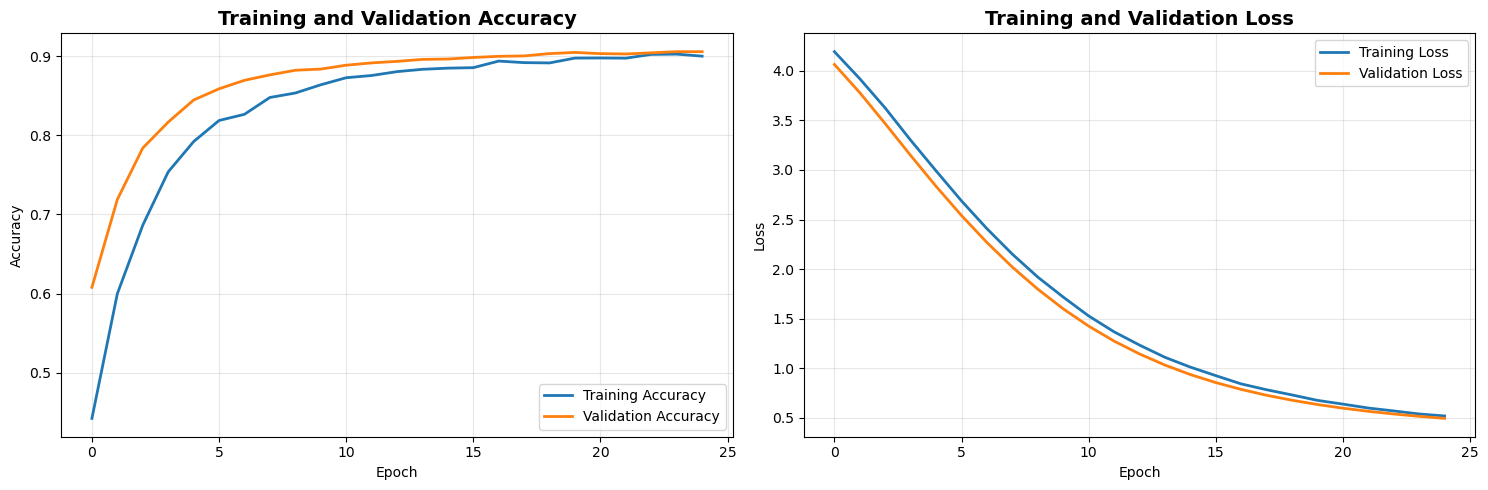

Final Accuracy - Training: 0.9217, Validation: 0.9056


In [31]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Final evaluation
train_acc = model.evaluate(train_ds, verbose=0)[1]
val_acc = model.evaluate(val_ds, verbose=0)[1]
print(f"Final Accuracy - Training: {train_acc:.4f}, Validation: {val_acc:.4f}")

In [32]:
model.save(CHECKPOINT_PATH)
print(f"Model saved as: {CHECKPOINT_PATH}")

Model saved as: .\deit_finetuned.keras


In [34]:
def predict_test_images(model, test_dir, breeds_list):
    test_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not test_files:
        print(">> No test images found!")
        return None
    
    results = []
    print(f"Predicting {len(test_files)} test images...")
    
    for file_name in tqdm(test_files):
        file_id = os.path.splitext(file_name)[0]
        file_path = os.path.join(test_dir, file_name)
        
        try:
            # Load and preprocess
            image = Image.open(file_path).convert('RGB')
            image = image.resize((IMG_SIZE, IMG_SIZE))
            image_array = np.array(image)
            
            # Preprocess for DeiT
            inputs = processor(image_array, return_tensors="tf")
            pixel_values = inputs['pixel_values']
            
            # Predict
            predictions = model(pixel_values)
            prob_vector = predictions[0].numpy() if isinstance(predictions, tuple) else predictions.numpy()
            
            # Get results
            predicted_idx = np.argmax(prob_vector[0])
            predicted_breed = breeds_list[predicted_idx]
            confidence = np.max(prob_vector[0])
            
            results.append({
                'id': file_id,
                'predicted_breed': predicted_breed.replace('_', ' ').title(),
                'confidence': confidence
            })
            
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            continue
    
    return pd.DataFrame(results)

In [35]:
# Run predictions
df_predictions = predict_test_images(model, TEST_DIR, BREEDS)
if df_predictions is not None:
    print("\nPrediction Results Sample:")
    print(df_predictions.head(10))

Predicting 10357 test images...


100%|██████████████████████████████████████████████████████████████████████████| 10357/10357 [2:04:44<00:00,  1.38it/s]


Prediction Results Sample:
                                 id     predicted_breed  confidence
0  000621fb3cbb32d8935728e48679680e    Japanese Spaniel    0.928029
1  00102ee9d8eb90812350685311fe5890             Samoyed    0.949792
2  0012a730dfa437f5f3613fb75efcd4ce      English Setter    0.740558
3  001510bc8570bbeee98c8d80c8a95ec1                 Pug    0.816522
4  001a5f3114548acdefa3d4da05474c2e     Tibetan Terrier    0.817934
5  00225dcd3e4d2410dd53239f95c0352f     Standard Poodle    0.222541
6  002c2a3117c2193b4d26400ce431eebd  Australian Terrier    0.916417
7  002c58d413a521ae8d1a5daeb35fc803             Samoyed    0.948196
8  002f80396f1e3db687c5932d7978b196     Irish Wolfhound    0.826242
9  0036c6bcec6031be9e62a257b1c3c442      Sussex Spaniel    0.832175


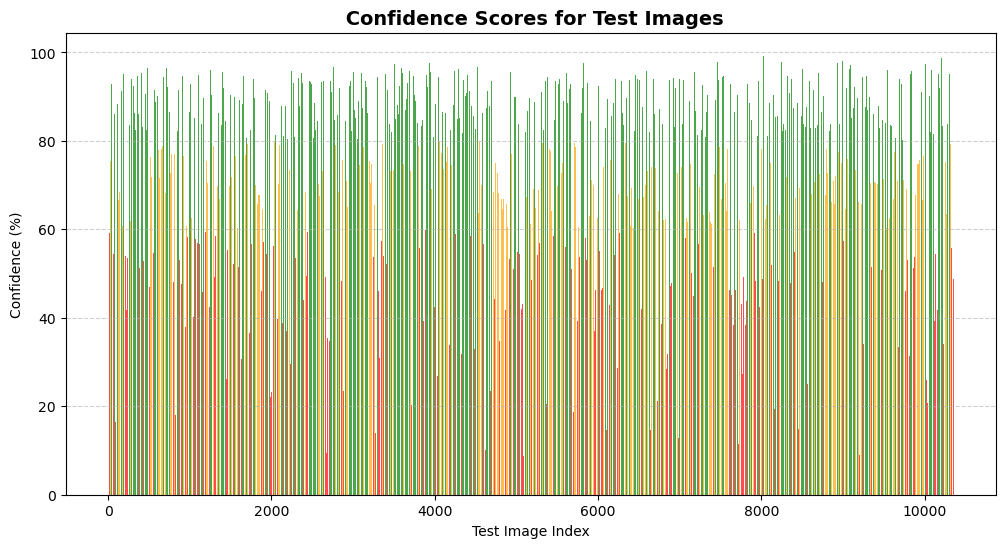

Predictions saved to: .\test_predictions2.csv


In [36]:
if df_predictions is not None:
    plt.figure(figsize=(12, 6))
    confidences = df_predictions['confidence'].values * 100
    
    plt.bar(range(len(confidences)), confidences, 
            color=['red' if c < 60 else 'orange' if c < 80 else 'green' for c in confidences],
            alpha=0.7)
    plt.xlabel('Test Image Index')
    plt.ylabel('Confidence (%)')
    plt.title(' Confidence Scores for Test Images', fontsize=14, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()
    
    # Save predictions
    results_csv = os.path.join(DATA_DIR, 'test_predictions2.csv')
    df_predictions.to_csv(results_csv, index=False)
    print(f"Predictions saved to: {results_csv}")

In [37]:
def attention_overlay(model, processor, img_path, img_size=224):
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return
    
    try:
        # Load image
        image = Image.open(img_path).convert('RGB')
        original_image = image.copy()
        
        # Preprocess for model
        image = image.resize((img_size, img_size))
        image_array = np.array(image)
        inputs = processor(image_array, return_tensors="tf")
        pixel_values = inputs['pixel_values']
        
        # Get predictions and attention
        predictions, attentions = model(pixel_values, return_attention=True)
        
        # Process attention from last layer
        last_attention = attentions[-1][0]  # First batch item
        mean_attention = np.mean(last_attention, axis=0)  # Average heads
        cls_attention = mean_attention[0, 1:]  # CLS token to patches
        
        # Reshape attention map
        grid_size = int(np.sqrt(cls_attention.shape[0]))
        attention_grid = cls_attention.reshape(grid_size, grid_size)
        attention_resized = cv2.resize(attention_grid, (img_size, img_size))
        
        # Normalize
        attention_resized = (attention_resized - attention_resized.min()) / (attention_resized.max() - attention_resized.min() + 1e-8)
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        axes[0].imshow(original_image)
        axes[0].set_title('Original Image', fontweight='bold')
        axes[0].axis('off')
        
        # Attention heatmap
        axes[1].imshow(attention_resized, cmap='hot')
        axes[1].set_title('Attention Heatmap', fontweight='bold')
        axes[1].axis('off')
        
        # Overlay
        axes[2].imshow(original_image.resize((img_size, img_size)))
        axes[2].imshow(attention_resized, cmap='hot', alpha=0.6)
        axes[2].set_title('Attention Overlay', fontweight='bold')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Prediction info
        predicted_idx = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        print(f"Prediction: {BREEDS[predicted_idx]}")
        print(f"Confidence: {confidence:.4f}")
        
    except Exception as e:
        print(f"Error in attention overlay: {e}")

Generating attention overlay:


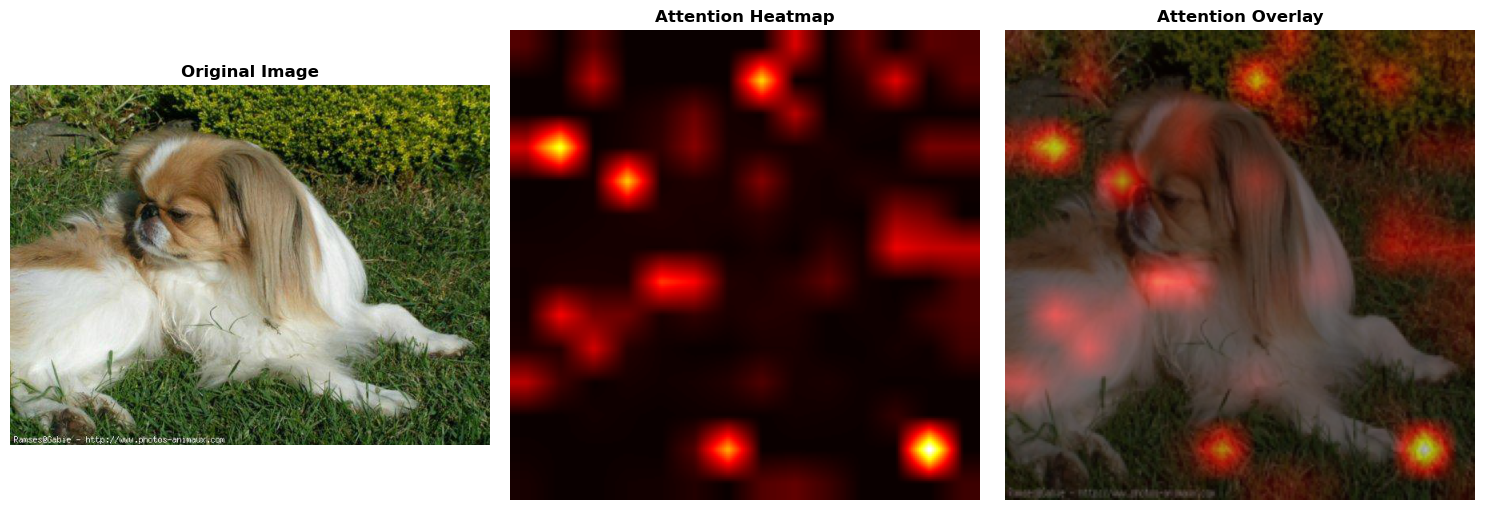

Prediction: japanese_spaniel
Confidence: 0.9280


In [38]:
# Get test files
test_files = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print("Generating attention overlay:")
attention_overlay(model, processor, test_files[0])

Generating attention overlay:


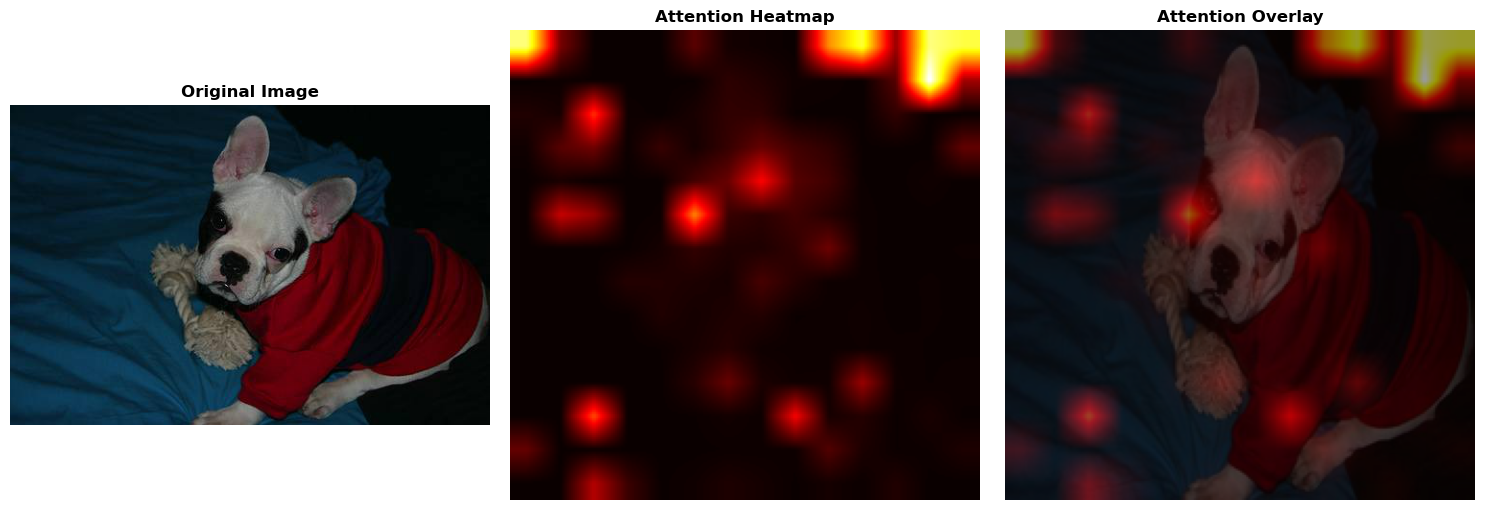

Prediction: french_bulldog
Confidence: 0.8263


In [39]:
print("Generating attention overlay:")
attention_overlay(model, processor, test_files[33])